In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier

In [2]:
# -------------------data import----------------------------------------------------------
# https://archive.ics.uci.edu/ml/datasets/heart+Disease
# Cleveland dataset
data_cl = pd.read_csv('../datasets/processed.cleveland_2.txt',\
                      sep=",", header=None) 
# Hungarian dataset
data_hu = pd.read_csv('../datasets/processed.hungarian_2.txt',\
                      sep=",", header=None) 
# Swiz dataset
data_sw = pd.read_csv('../datasets/processed.switzerland_2.txt',\
                      sep=",", header=None)
# Long beach dataset
data_va = pd.read_csv('../datasets/processed.va_2.txt',\
                      sep=",", header=None)

# Merge all datasets into one dataset
data = pd.concat([data_cl,data_hu,data_sw,data_va]).replace('?', np.nan).reset_index(drop=True)
# Column names, according to the web source
data.columns = ['age', 'sex','cp','trestbps','chol','fbs','restecg',\
                'thalach','exang','oldpeak','slope','ca','thal','num']

# Filter out datapoints with missing values
filtered_data = data[data['trestbps'].notnull()]
filtered_data = filtered_data[filtered_data['chol'].notnull()]
filtered_data = filtered_data[filtered_data['age'].notnull()]
filtered_data = filtered_data[filtered_data['sex'].notnull()]
filtered_data = filtered_data[filtered_data['restecg'].notnull()]
filtered_data = filtered_data.drop(filtered_data[filtered_data.chol == 0].index).reset_index(drop=True)
filtered_data = filtered_data.drop(filtered_data[filtered_data.chol == '0'].index).reset_index(drop=True)

# Make label class into binary
filtered_data['num'] = filtered_data['num'].astype(bool).astype(int).values.tolist()
# Make relevant columns into list values
filtered_data['chol'] = filtered_data['chol'].astype(int)
filtered_data['trestbps'] = filtered_data['trestbps'].astype(int)
filtered_data['age'] = filtered_data['age'].astype(int)
filtered_data['sex'] = filtered_data['sex'].astype(int)
filtered_data['restecg'] = filtered_data['restecg'].astype(int)


# Divide into two subsets (sick and healthy) for data generation
sick = filtered_data.loc[filtered_data['num'] == 1]
good = filtered_data.loc[filtered_data['num'] == 0]

# Compute avg and var for the sensor values
avg_chol_sick = np.mean(sick['chol'].astype(np.float).values.tolist())
std_chol_sick =  np.std(sick['chol'].astype(np.float).values.tolist())
avg_chol_good = np.mean(good['chol'].astype(np.float).values.tolist())
std_chol_good = np.std(good['chol'].astype(np.float).values.tolist())

avg_bp_sick = np.mean(sick['trestbps'].astype(np.float).values.tolist())
std_bp_sick = np.std(sick['trestbps'].astype(np.float).values.tolist())
avg_bp_good = np.mean(good['trestbps'].astype(np.float).values.tolist())
std_bp_good = np.std(good['trestbps'].astype(np.float).values.tolist())

label = filtered_data.num.astype(bool).astype(int).values.tolist() # binary classes, heart disease or not
age = filtered_data.age.values.tolist()
bp = filtered_data.trestbps.values.tolist() #blood pressure
chol = filtered_data.chol.values.tolist() # cholesterol
ecg = filtered_data.restecg.values.tolist() #electrocardiography

sex = filtered_data.sex.values.tolist()
bloodsugar = filtered_data.fbs.values.tolist() # fasting bloodsugar
maxhr = filtered_data.thalach.values.tolist() # max heart rate
exang = filtered_data.exang.astype(int).values.tolist() # exercise induced angia
oldpeak = filtered_data.oldpeak.values.tolist() # ST depression induced by exercise relative to rest
slope = filtered_data.slope.values.tolist() # the slope of the peak exercise ST segment, 1: upsloping, 2: flat, 3: downsloping
ca = filtered_data.ca.values.tolist() # number of major vessels (0-3) colored by flourosopy
thal = filtered_data.thal.values.tolist() #3 = normal; 6 = fixed defect; 7 = reversable defect

In [3]:
from sklearn.gaussian_process.kernels import  WhiteKernel, RBF, DotProduct, ExpSineSquared, Matern
from sklearn.gaussian_process.kernels import RationalQuadratic, Sum, Product, ConstantKernel

In [5]:
#Kernel exploring
#x = StandardScaler().fit_transform(np.transpose([age,sex,chol,bp,ecg,exang]))
x = np.transpose([age,sex,chol,bp,ecg,exang])
y = np.transpose(label)

kernel = 1*RBF( length_scale =1) + WhiteKernel ( noise_level =0.1)
gpc = GaussianProcessClassifier(kernel=kernel)

kernels1 = [WhiteKernel(noise_level =0.1) + 2**1*RBF(length_scale =1), \
           WhiteKernel(noise_level =0.1) + 2**1*DotProduct(), \
           WhiteKernel(noise_level =0.1) + 2**1*Matern()]
kernelDescription1 = ["White and RBF","White and DotProduct","White and Matern"]

kernels2 = [WhiteKernel(noise_level =0.1) + 2**1*RationalQuadratic(), \
           WhiteKernel(noise_level =0.1) + ConstantKernel(), \
           WhiteKernel(noise_level =0.1) + 2**1*Product(RBF(),DotProduct()),\
           WhiteKernel(noise_level =0.1) + 2**1*Sum(RBF(),DotProduct())]
kernelDescription2 = ["White and RQ","White and Constant","White and product of RBF and DotProduct","White and sum of RBF and DotProduct"]

#kernels = kernels2
#kernelDescription = kernelDescription2

kernels = kernels1 + kernels2 
kernelDescription = kernelDescription1 + kernelDescription2

splits = 2
kernelIndex = 0

AvBestScore = 0
BestKernelIndex = 0

for kernel in kernels:
    
    gpc = GaussianProcessClassifier(kernel=kernel)
    sc = cross_validate(gpc, x, y.ravel(), cv=splits)
    
    if(np.mean(sc["test_score"]) > AvBestScore):
        AvBestScore = np.mean(sc["test_score"])
        BestKernelIndex = kernelIndex
    
    print("------------Kernel info--------------")
    print("Kernel: ", kernelDescription[kernelIndex])
    print("Average score: ", np.mean(sc["test_score"]))
    print("Best score: ", np.max(sc["test_score"]))
    print("Worst score: ", np.min(sc["test_score"]))
    print("-------------------------------------")
    
    kernelIndex = kernelIndex + 1

print("------------Result---------------")
print("Best kernel: ", kernelDescription[BestKernelIndex])
print("Best average score: ", AvBestScore)
print("---------------------------------") 
    

------------Kernel info--------------
Kernel:  White and RBF
Average score:  0.6335311572700297
Best score:  0.7181008902077152
Worst score:  0.5489614243323442
-------------------------------------


KeyboardInterrupt: 

In [6]:
#Visualiation
#x = np.transpose([age,sex,chol,bp,ecg,exang])

gpc = GaussianProcessClassifier(kernel=kernels[1]).fit(x,y.ravel())

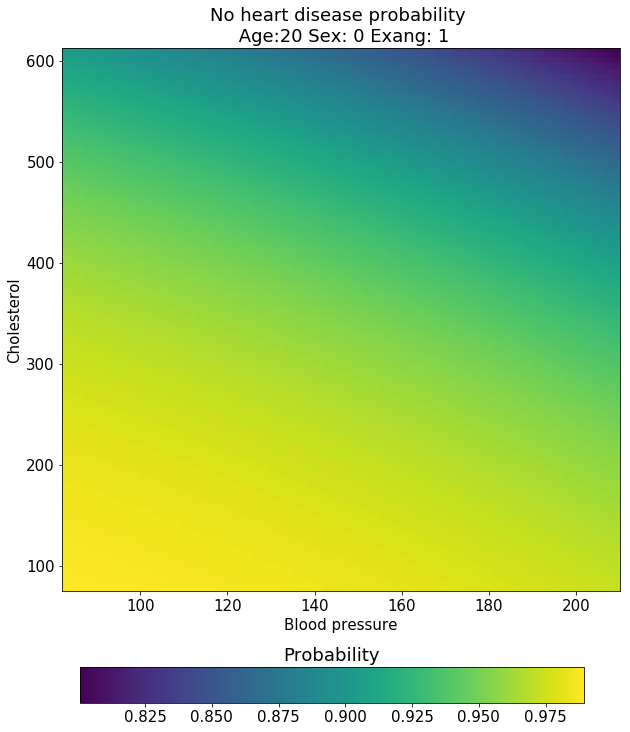

In [57]:

#([age,sex,chol,bp,ecg,exang])

# Stationary points
OneAge = 20 #int(np.mean(age));
OneSex = 0;
OneEcg = 0;
OneExang = 1;

# Variable points
bpx = np.transpose(bp)
choly = np.transpose(chol)

xx = np.linspace(np.min(bpx), np.max(bpx), 100)
yy = np.linspace(np.min(choly)-10, np.max(choly)+10, 100).T
xx, yy = np.meshgrid(xx, yy)
pointsOfInterest = np.c_[xx.ravel(), yy.ravel()]

LPOI = int(pointsOfInterest.size/2) # Length PointsOf Interest

pointsOfInterest = np.transpose(pointsOfInterest)

bpFull = pointsOfInterest[0,:]
cholFull = pointsOfInterest[1,:]

Xfull = np.transpose([np.ones(LPOI).T*OneAge, np.ones(LPOI).T*OneSex, cholFull, bpFull, np.ones(LPOI).T*OneEcg, np.ones(LPOI).T*OneEcg]) #+ np.ones(lengthXfull)*OneSex

#print(np.transpose([age,sex,chol,bp,ecg,exang]))
#print(Xfull)
#print(pointsOfInterest[:,0])

probas = gpc.predict_proba(Xfull)

probas = probas[:,0]

fig = plt.figure(num=None, figsize=(10, 10))#, dpi=80, facecolor='w', edgecolor='k')
plt.rc('font', size=15)
ax = fig.gca()
imshow_handle = ax.imshow(probas.reshape((100, 100)),extent=(np.min(bpx)-10, np.max(bpx)+10, np.min(choly)-10, np.max(choly)+10), origin='lower')
ax.set_aspect('auto')
#plt.scatter(x[:, 2], x[:, 3], c=y, edgecolors='k')
ax.set_xlabel('Blood pressure')
ax.set_ylabel('Cholesterol')
String = ''.join(['No heart disease probability \n Age:',  str(OneAge), ' Sex: ', str(OneSex), ' Exang: ', str(OneExang)])
ax.set_title(String)
ax2 = plt.axes([0.15, -0.03, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax2, orientation='horizontal')
plt.show()

In [58]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

ValueError: Argument Z must be 2-dimensional.

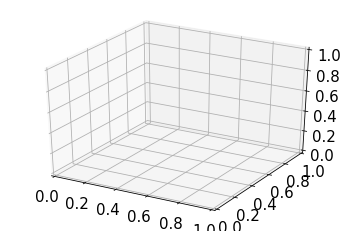

In [61]:
fig = plt.figure()
ax = fig.gca(projection='3d')

#([age,sex,chol,bp,ecg,exang])

# Stationary points
OneAge = 20 #int(np.mean(age));
OneSex = 0;
OneEcg = 0;
OneExang = 1;

# Variable points
bpx = np.transpose(bp)
choly = np.transpose(chol)

xx = np.linspace(np.min(bpx), np.max(bpx), 100)
yy = np.linspace(np.min(choly)-10, np.max(choly)+10, 100).T
xx, yy = np.meshgrid(xx, yy)
pointsOfInterest = np.c_[xx.ravel(), yy.ravel()]

LPOI = int(pointsOfInterest.size/2) # Length PointsOf Interest

pointsOfInterest = np.transpose(pointsOfInterest)

bpFull = pointsOfInterest[0,:]
cholFull = pointsOfInterest[1,:]

Xfull = np.transpose([np.ones(LPOI).T*OneAge, np.ones(LPOI).T*OneSex, cholFull, bpFull, np.ones(LPOI).T*OneEcg, np.ones(LPOI).T*OneEcg]) #+ np.ones(lengthXfull)*OneSex

#print(np.transpose([age,sex,chol,bp,ecg,exang]))
#print(Xfull)
#print(pointsOfInterest[:,0])

probas = gpc.predict_proba(Xfull)
probas = probas[:,0]

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

X = xx
Y = yy
Z = probas


# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()